In [17]:
import pandas as pd
import numpy as np
from collections.abc import Iterable
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import time
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns

# define gvars
SEED = 1080
VCHUNK = 64
NUM_CLASSES = 12

BATCH_SIZE = 32
SPLIT = 0.2
EPOCHS = 50
LR = 0.001
METRIC = 'val_accuracy'
MIN_DELTA = 1e-4
PATIENCE = 100
THRESHOLD = 0.5

# Set random seed
tf.random.set_seed(SEED)

# import from csv to dataframe
df = pd.read_csv('wnl/WNL_TLS_Dataset_ECH.csv', sep='\t')
esni = pd.read_csv('wnl/WNL_TLS_Dataset_ESNI.csv', sep='\t')

# set checkpoint path and filename
check_name = "WNL_CLASS_CNN.chkp"
check_path = "checkpoint/" + check_name

# define our callbacks
callbacks = [

    # define checkpoint callback
    tf.keras.callbacks.ModelCheckpoint (
        check_path,
        monitor= 'val_accuracy',
        verbose= 1,
        save_best_only= True,
        save_weights_only= True,
        mode= 'auto',
        save_freq='epoch',
        options=None,
        initial_value_threshold=THRESHOLD,
    ),

    # # define early stopping callback
    # tf.keras.callbacks.EarlyStopping(
    #     monitor=METRIC,
    #     min_delta=MIN_DELTA,
    #     patience=PATIENCE,
    #     verbose=1
    # ),

]


In [2]:
'''https://tls13.xargs.org/#client-hello/annotated'''

def flatten(L):
    '''flattens a list of nested list of arbitrary depth into a single concatenated list'''
    for x in L:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

def padding(A, size):
    '''pads a given list to a given length'''
    t = size - len(A)

    return np.pad(A, pad_width=(0, t), mode='constant')

def parse_CHP(p):
    '''
    implements the Shamsimukhametov et al. bytes recomposition algorithm
    builds a fixed length feature vector from clienthello message
    '''
    T = []
    L = []
    V = []

    handshake_len = sum(p[3:5])
    clienthello_len = sum(p[6:9])
    sid_len = p[43]
    i = 44+sid_len

    sid = p[44:i]
    ciphersuite_len = sum(p[i:i+2])
    ciphersuite = p[i+2:i+2+ciphersuite_len]
    i += 4 + ciphersuite_len

    ext_len = sum(p[i:i+2])
    i = i+2
    
    T.append(padding(sid, 32))
    L.append(handshake_len)
    L.append(clienthello_len)
    L.append(sid_len)
    L.append(ciphersuite_len)
    L.append(ext_len)
    V.append(ciphersuite)
    
    end = i + ext_len
    count = 0   

    while (i < len(p)):

        n_ext_id = sum(p[i:i+2])
        i+=2
        
        n_ext_len = sum(p[i:i+2])
        i+=2

        T.append(n_ext_id)
        L.append(n_ext_len)
        V.append(p[i:i+n_ext_len])
        i+=n_ext_len

    T = padding(list(flatten(T)),40)
    L = padding(list(flatten(L)),13)
    V = list(flatten(V))
    VC = V[:VCHUNK]

    return np.concatenate((T,L,VC))

def parse_SHP(p):
    '''
    implements the Shamsimukhametov et al. bytes recomposition algorithm
    builds a fixed length feature vector from serverhello message
    '''
    T = []
    L = []
    V = []

    handshake_len = sum(p[3:5])
    serverhello_len = sum(p[6:9])
    sid_len = p[43]
    i = 44+sid_len

    sid = p[44:i]
    ciphersuite = sum(p[i:i+2])
    i += 3

    ext_len = sum(p[i:i+2])
    i = i+2
    
    T.append(padding(sid, 32))
    T.append(ciphersuite)
    L.append(handshake_len)
    L.append(serverhello_len)
    L.append(sid_len)
    L.append(ext_len)

    end = i + ext_len
    count = 0    
    
    while (i < len(p)):

        n_ext_id = sum(p[i:i+2])
        i+=2
        
        n_ext_len = sum(p[i:i+2])
        i+=2

        T.append(n_ext_id)
        L.append(n_ext_len)
        V.append(p[i:i+n_ext_len])
        i+=n_ext_len

    T = padding(list(flatten(T)),40)
    L = padding(list(flatten(L)),10)
    V = list(flatten(V))
    VC = V[:VCHUNK]

    return np.concatenate((T,L,VC))

def parse_payload(CH,SH):
    '''builds a concatenated fixed length feature vector of recomposed bytes'''
    chp  = np.fromstring(CH, dtype=int, sep=',')
    shp  = np.fromstring(SH, dtype=int, sep=',')
    chv = parse_CHP(chp)
    shv = parse_SHP(shp)
    return np.concatenate((chv,shv))

In [3]:
# Transform according to recomposition algorithm
df['X'] = df.apply(lambda row : parse_payload(row['ClientHello'], row['ServerHello']), axis=1)

In [4]:
# Encode classes into integers as terget variable vector y
labels = df.Label.unique()
df['Label'] = df['Label'].astype('category')
df['target'] = df['Label'].cat.codes
y = df['target'].to_numpy()

In [5]:
# expand array to proper dims
dfx = pd.DataFrame(df['X'].tolist()).add_prefix("x")
X = dfx.to_numpy(dtype=np.int16)
X = X/256


In [6]:
# split the training data into train and val_test sets using categorical stratification
X_train, X_val_test, y_train , y_val_test = train_test_split(   X,
                                                                y,
                                                                stratify=y,
                                                                shuffle=True,
                                                                test_size=SPLIT,
                                                                random_state=SEED
                                                                )

# split the val_test data into val and test sets using categorical stratification
X_val, X_test, y_val , y_test = train_test_split(       X_val_test,
                                                        y_val_test,
                                                        test_size=0.5,
                                                        random_state=SEED
                                                        )
# get sizes
len_a = len(X_train)
len_b = len(X_train[5])

# reshape to fit the model
X_train = tf.reshape(X_train,(len_a,len_b,1))

# check for data leakage
print('Data Leak Check')
# need method to check for duplicate rows in data
print(len(X_train))
print(len(X_val))
print(len(X_test))
print(len(X_train), len(y_train), len(X_val_test), len(y_val_test), len(X_val), len(X_test), len(y_val), len(y_test)), print(len(X_train[5]))

Data Leak Check
2792
349
349
2792 2792 698 698 349 349 349 349
231


2023-04-04 13:16:23.856966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 13:16:24.096412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 13:16:24.096553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 13:16:24.099416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

(None, None)

In [7]:
# compose the model architecture function
def compose_model():
    in_layer = layers.Input(shape=(len_b,1))
    x = layers.Conv1D(256, 3, padding='valid', strides=1, activation="relu", input_shape=(len_b,1))(in_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D()(x)
    x = layers.Conv1D(128, 3, padding='valid', strides=1, activation="relu", input_shape=(len_b,1))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D()(x)
    x = layers.Conv1D(64, 3, padding='valid', strides=1, activation="relu", input_shape=(len_b,1))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D()(x)

    # generic stacked dense softmax classifier
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(len_b, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    out_layer = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=in_layer, outputs=out_layer)

# instantiate the model
model = compose_model()

# load previously trained weights
#status = model.load_weights(check_path).expect_partial()

# inspect model stack
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 231, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 229, 256)          1024      
                                                                 
 batch_normalization (BatchN  (None, 229, 256)         1024      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 114, 256)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 112, 128)          98432     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 128)         512   

In [8]:
# compile and fit the model to the data
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              metrics=['accuracy'])

# save model plot
plot_model(model, to_file='1DCNN.png')

# start timer
start = time.time()
# fit the model
history = model.fit (   X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=callbacks,
                        )
# stop timer
end = time.time()

Epoch 1/50


2023-04-04 13:16:27.951947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-04-04 13:16:29.611725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-04 13:16:29.636103: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fa41c018c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-04 13:16:29.636123: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-04-04 13:16:29.667261: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-04 13:16:29.924640: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime 

88/88 [==============================] - ETA: 0s - loss: 1.8185 - accuracy: 0.4112
Epoch 1: val_accuracy did not improve from 0.50000
88/88 [==============================] - 7s 8ms/step - loss: 1.8185 - accuracy: 0.4112 - val_loss: 2.4524 - val_accuracy: 0.0917
Epoch 2/50
77/88 [=========================>....] - ETA: 0s - loss: 0.9837 - accuracy: 0.6315
Epoch 2: val_accuracy did not improve from 0.50000
88/88 [==============================] - 0s 4ms/step - loss: 0.9698 - accuracy: 0.6375 - val_loss: 2.4662 - val_accuracy: 0.0917
Epoch 3/50
77/88 [=========================>....] - ETA: 0s - loss: 0.7654 - accuracy: 0.7159
Epoch 3: val_accuracy did not improve from 0.50000
88/88 [==============================] - 0s 4ms/step - loss: 0.7586 - accuracy: 0.7192 - val_loss: 2.7394 - val_accuracy: 0.0917
Epoch 4/50
77/88 [=========================>....] - ETA: 0s - loss: 0.6422 - accuracy: 0.7411
Epoch 4: val_accuracy did not improve from 0.50000
88/88 [==============================] - 0s 

In [9]:
# Make predictions on our test data
y_pred = model.predict(X_test)
y_pred = np.rint(y_pred)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

11/11 [==============================] - 0s 1ms/step
[ 0  4  9  9  9  1  9  4 10  6  4  9  5  9  4 11  7  9  6  6  2  8 10  6
 10  0  0  5  9  4 11  9  9  9 10 11 11 11  7 11  4  8  7  1 10  4  9  9
  9  9  1  9  9  0  6  0 11  4  2  9  6  0  7  4  2  0 11  9  6  4  9  6
  6  9  9  5 10  7  8  4  8  4  1  5  9 10  1  0  7  0  9  4  1  2  9 10
 10  9  9  4  6  7  5  9 11 11  5  9  0  0  7  7  9  9  9  5  1 10  9  1
  5  4  7 11  1  4  0  9  1  2  9  4  1  4  1  6  3  4 11  5  2  6  3  9
  9  1  0  4  9  9  3  4 10  2  1 11 10  1  5  0  7  9  4  5 10  9 10  6
  9  8  5  7  5  2  7 10  4  8  0  1  9 11 11  7  6  3 10  3 10  2  6 11
  6  9  1  2  1  9  9  9  9  1  1  9 11  0  7  0  6  4  4 10 10 10  7  0
  9  4  0 11  5  1  7  7  4  5  9  3 10 11  9  4  6  1  1 10 10 10 11  9
 11  3  9  7  1  4  3 10  9  6  0  9  4 10 11  6  9  6  8  9  9 11  7  9
  9 10  4  4  9  9 10  7 11  9  6 11  5  9  4  9  6  9  0 10 11  4  2  4
  3  9  4  6  4  6  9  6 10  4  5  9  2  9  1  9  1  8  1  9  9  7  9 1

In [10]:
# Evaluate the models performance (I hope this isnt garbage)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

  AppleMusic     0.7391    0.8095    0.7727        21
         Web     0.7353    0.8333    0.7812        30
   Kinopoisk     1.0000    1.0000    1.0000        12
LiveFacebook     1.0000    1.0000    1.0000        10
 LiveYouTube     0.8537    0.8974    0.8750        39
     Netflix     0.9444    0.9444    0.9444        18
  PrimeVideo     0.9375    1.0000    0.9677        30
  SoundCloud     0.8462    1.0000    0.9167        22
     Spotify     0.6000    1.0000    0.7500         6
       Vimeo     0.8902    0.7935    0.8391        92
 YandexMusic     0.8788    0.7073    0.7838        41
     YouTube     1.0000    1.0000    1.0000        28

    accuracy                         0.8711       349
   macro avg     0.8688    0.9155    0.8859       349
weighted avg     0.8772    0.8711    0.8705       349



In [11]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Training Time: "+str(end-start))

Accuracy: 0.8710601719197708
Training Time: 23.27537441253662


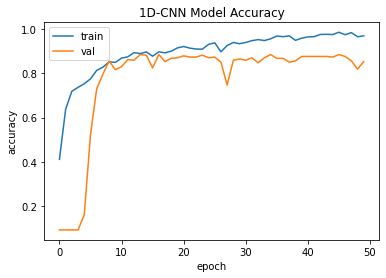

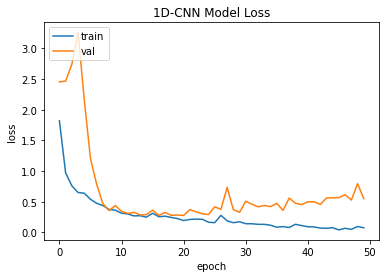

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('1D-CNN Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('cnn_acc.jpg')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('1D-CNN Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('cnn_loss.jpg')
plt.show()

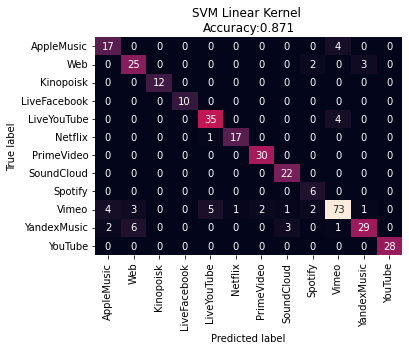

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns


# plot a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = labels, columns = labels)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cbar=False)
plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()